In [1]:
import os
import glob

import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append("neuroformer")
# sys.path.append('/home/antonis/projects/slab/git/neuroformer/neuroformer')

import pandas as pd
import numpy as np

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from model_perceiver import GPT, GPTConfig
from trainer import Trainer, TrainerConfig
from utils import *


from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import matplotlib.pyplot as plt
import seaborn as sns
set_plot_params()
%matplotlib inline
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [2]:
from utils import set_seed
set_seed(25)

In [3]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

stim_folder = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/Downloads/OneCombo3/stimuli"
video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

[]
im_sack size: torch.Size([5760, 1, 64, 112])


In [7]:
video_stack[2, 1].permute(1, 2, 0).shape

torch.Size([64, 112, 1])

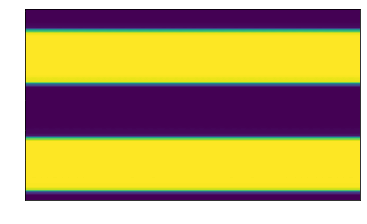

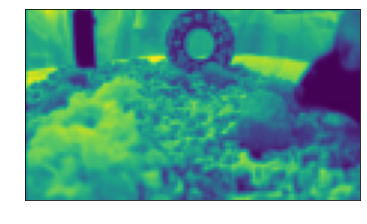

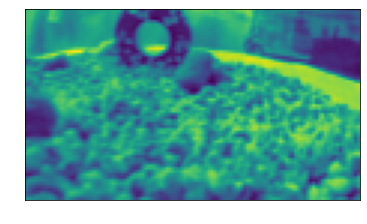

In [4]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [5]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [7]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [8]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [9]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = 52   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [10]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(df['Trial'].max() // 20):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [11]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)
dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}')

Length: 25612 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941


In [12]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [13]:
from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=False,
                        n_state_layers=6, n_state_history_layers=6, n_stimulus_layers=6,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb= True,
                        id_drop=0.1, im_drop=0.1)
model = GPT(mconf)
device = torch.cuda.current_device if torch.cuda.is_available else 'cpu'
model_path = "/home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [65]:
def att_interval(model, module, loader, n_blocks, block_size, pad_key=None):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = None
    data = dataset
    pbar = tqdm(enumerate(loader), total=len(loader))
    atts = np.zeros(frame_block_size)
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward the model
        _, _, _, = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        # att = np.zeros(len(feat_encodings))
        score = AttentionVis.get_attention(module, n_blocks, T, pad)
        for n, step in enumerate(score):
            # weight each attention by how many units there are
            score[n] /= (n + 1)

        if attention_scores is None:
                attention_scores = score[None, ...]
        else:
            attention_scores = np.vstack((attention_scores, score[None, ...]))

            # att_dict[int(y['id'][:, n])] = step
        # atts[tuple(x['interval'].cpu().numpy().flatten())] = att_dict
    return attention_scores
        # take attentions from last step

In [87]:
def att_models(model, module, loader, n_blocks, block_size, pad_key=None, sum_=True):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = np.zeros(mconf.id_vocab_size)
    pbar = tqdm(enumerate(loader), total=len(loader))
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward model to calculate attentions
        _, _, _ = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        att = np.zeros(mconf.id_vocab_size)
        score = AttentionVis.get_attention(module, n_blocks, T, pad)
        score = np.sum(score, axis=0)   # sum over all heads 
        score = np.sum(score, axis=0)   # sum over all steps
        # take attentions from last step
        # if score.size >= 1: score = score[-1]
        # scores.append(score)
        real_ids = x['id'][..., :T - pad].flatten()
        for idx, code in enumerate(real_ids):
            """ 
            for each code in scores,
            add its score to the array
            """
            code = int(code.item())
            att[code] += score[idx]
        attention_scores = np.vstack((attention_scores, att))
        if sum_:
            attention_scores = attention_scores.sum(axis=0)
    return attention_scores

In [88]:
from attentionVis import AttentionVis

loader = DataLoader(dataset, shuffle=False, pin_memory=False,
                             batch_size=1, num_workers=1)
iterable = iter(loader)

In [89]:
x, y = next(iterable)
model = model.to('cpu')
_, _, _ = model(x)

In [99]:
att_step = AttentionVis.get_attention(model.neural_visual_transformer.neural_state_block, 6, id_block_size, x['pad'])
att_step_stim = AttentionVis.get_attention(model.neural_visual_transformer.neural_state_stimulus, 6, id_block_size, 0)
print(att_step.shape, att_step_stim.shape)

(8, 1, 52) (8, 52, 560)


In [91]:
att_state_int = att_models(model, model.neural_visual_transformer.neural_state_block,
                        loader, model.config.n_state_layers, mconf.id_block_size, 'pad', False)

100%|██████████| 3670/3670 [01:00<00:00, 60.39it/s]


In [100]:
# att_state_int_corr = np.corrcoef(att_state_int[1:], att_state_int[:-1])
att_state_int_corr = np.corrcoef(att_state_int.T)

/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [101]:
att_state_int_corr.shape

(168, 168)

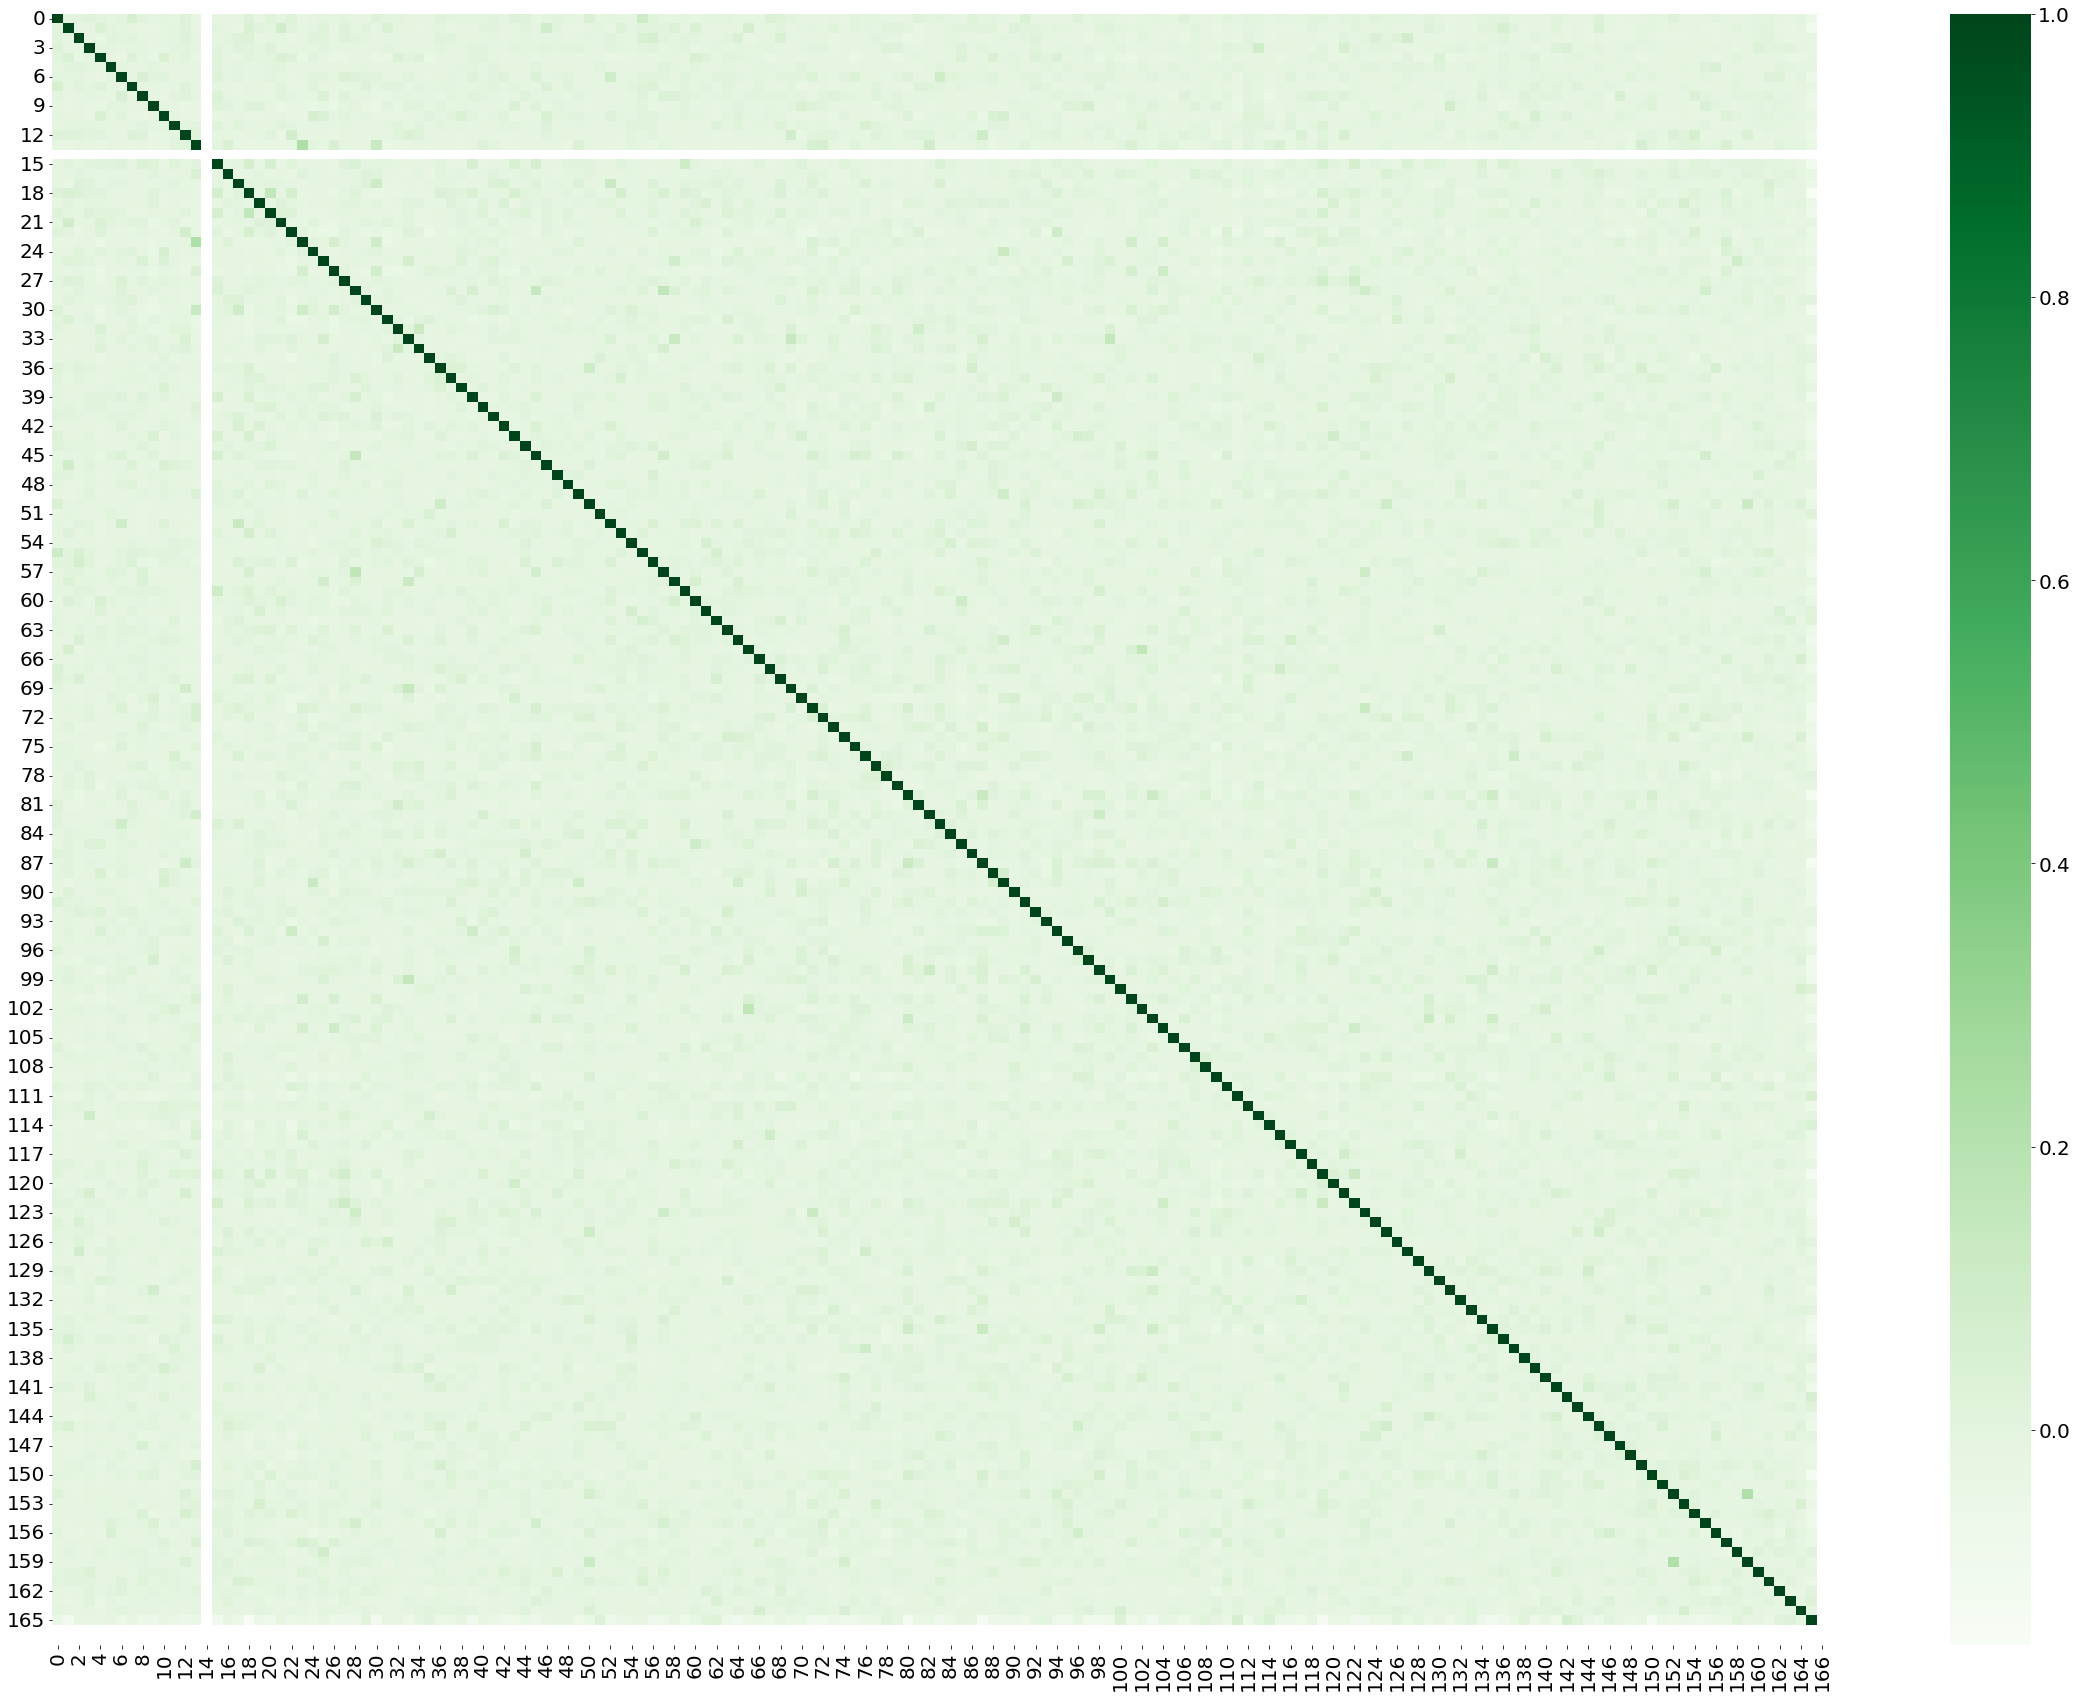

In [102]:
set_plot_white()
plt.figure(figsize=(40,30))
sns.heatmap(att_state_int_corr, cmap="Greens", annot=False)
plt.show()

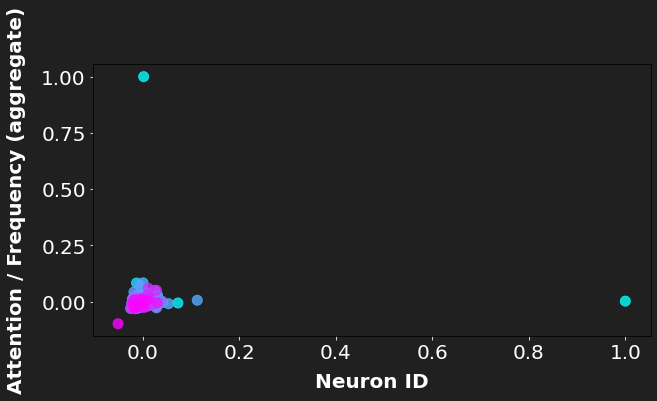

In [103]:
set_plot_black()

plt.figure(figsize=(10,5))
color_list = sns.color_palette("cool", n_colors=len(att_state_int_corr))
plt.ylabel('Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(att_state_int_corr[0], att_state_int_corr[1], marker='o', alpha=0.8, s=100, color=color_list)

In [104]:
state_atts = att_models(model, model.neural_visual_transformer.neural_state_block,
                        loader, model.config.n_state_layers, mconf.id_block_size, 'pad')
history_atts = att_models(model, model.neural_visual_transformer.neural_state_history_block,
                          loader, model.config.n_state_history_layers, mconf.id_block_size, 'pad_prev') 

100%|██████████| 3670/3670 [01:00<00:00, 60.95it/s]


In [106]:
state_att = state_atts[df['ID'].unique()] / df.groupby(['ID']).size()
history_att = history_atts[df['ID'].unique()] / df.groupby(['ID']).size()
total_att = state_att + history_att / 2

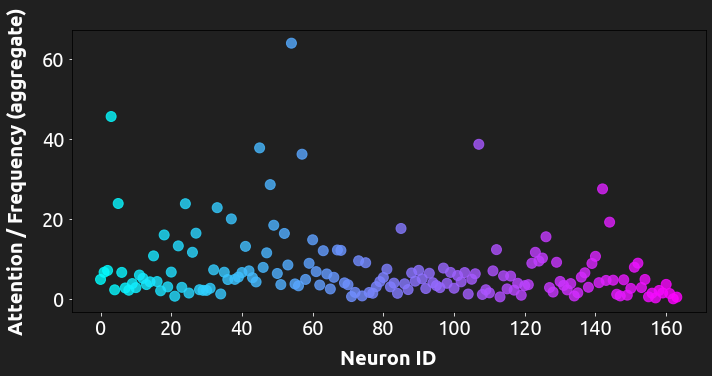

In [107]:
import seaborn as sns
set_plot_black()
# cool, gnuplot2_r, hsv, 'pairedk
color_list = sns.color_palette("cool", n_colors=len(history_att))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelpad'] = 17
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['patch.set_facecolor'] = 'white'
# plt.rcParams['savefig.facecolor']= 'white'
plt.rcParams['axes.titlepad'] = 25 

plt.figure(figsize=(10,5))
plt.ylabel('Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(np.arange(len(state_att)), state_att, marker='o', alpha=0.8, s=100, color=color_list)
    # plt.legend()
# plt.scatter(np.arange(len(history_att)), history_att, marker='x', alpha=0.5, color=color_list)

plt.tight_layout()
# plt.savefig('attentions-frequency.png', dpi=400)

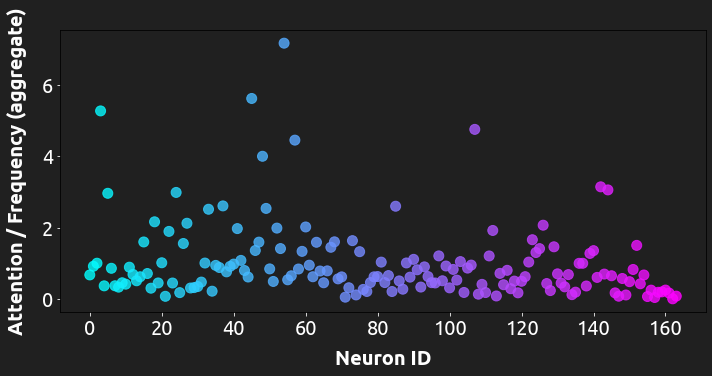

In [108]:
plt.figure(figsize=(10,5))
plt.ylabel('Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(np.arange(len(history_att)), history_att, marker='o', alpha=0.8, s=100, color=color_list)
    # plt.legend()
# plt.scatter(np.arange(len(history_att)), history_att, marker='x', alpha=0.5, color=color_list)

plt.tight_layout()

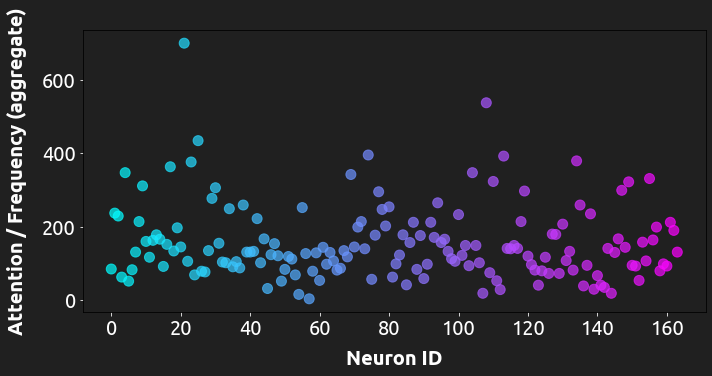

In [109]:
plt.figure(figsize=(10,5))
plt.ylabel('Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(np.arange(len(history_att)), df.groupby(['ID']).size(), marker='o', s=100, alpha=0.7, color=color_list)
    # plt.legend()
# plt.scatter(np.arange(len(history_att)), history_att, marker='x', alpha=0.5, color=color_list)

plt.tight_layout()

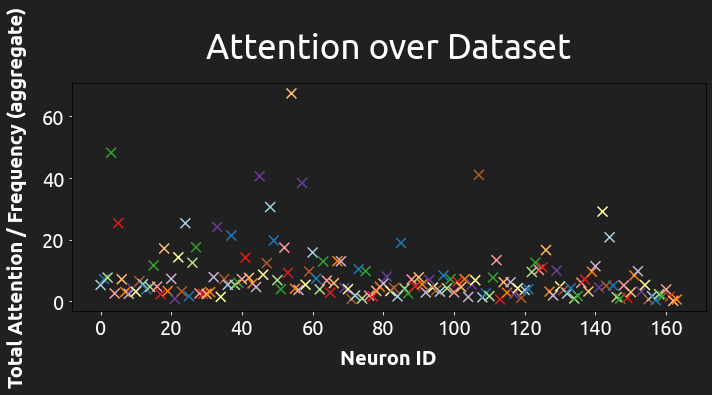

In [110]:
import seaborn as sns
color_list = sns.color_palette("Paired", n_colors=len(total_att))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelpad'] = 17
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['patch.set_facecolor'] = 'white'
# plt.rcParams['savefig.facecolor']= 'white'
plt.rcParams['axes.titlepad'] = 25 

plt.figure(figsize=(10,5))
plt.title('Attention over Dataset', fontsize=35)
plt.ylabel('Total Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(np.arange(len(total_att)), total_att, marker='x', s=100, alpha=1, color=color_list)
    # plt.legend()

plt.tight_layout()
plt.savefig('attentions-frequency.png', dpi=400)

In [111]:
total_att.median(axis=0)

5.025072419553166

In [112]:
matrix = [[i for i in range(4)],
          [i for i in range(5, 10)],
          [i for i in range(10, 15)],
          [i for i in range(15, 20)]]
r = range(len(matrix))

In [113]:
x, y = next(iter(loader))

In [114]:
x['id'].shape

torch.Size([1, 52])

In [115]:
pp = [1, 2, 3]

In [116]:
# \\ write a function to insert a value in a list
def insert(lst, index, value):
    lst.insert(index, value)
    return lst

insert(pp, 2, 'a')

[1, 2, 'a', 3]

In [117]:
def get_token_embeddings(neuron_list):
    embeddings = {}
    for idn in neuron_list:
        x_id = torch.tensor([idn]).unsqueeze(0)
        emb = model.tok_emb(x_id)
        embeddings[idn] = emb.flatten().detach().cpu().numpy()
    return embeddings

model.to('cpu')
token_embeddings = get_token_embeddings(df['ID'].unique())

In [118]:
from scipy.spatial.distance import cosine

def arrange_vectors(vectors):
    arranged_vectors = {}
    for key, value in vectors.items():
        arranged_vectors[key] = []
        for key2, value2 in vectors.items():
                cosine_sim = 1 - cosine(value, value2)
                arranged_vectors[key].append((key2, cosine_sim))
    return arranged_vectors

arrange_embeddings = arrange_vectors(token_embeddings)

In [119]:
id_ref = 30 # total_att.argmax()
df_arr_embd = pd.DataFrame.from_records(arrange_embeddings[id_ref], columns=['ID', 'cosine_sim']).sort_values(by='cosine_sim', ascending=False)

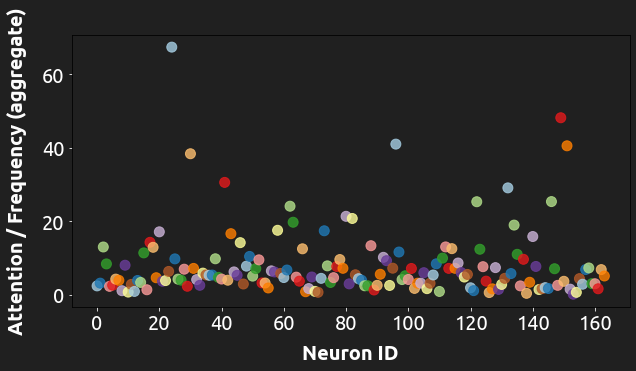

In [120]:
plt.figure(figsize=(10,5))
plt.ylabel('Attention / Frequency (aggregate)', labelpad=15)
plt.xlabel('Neuron ID', labelpad=10)
plt.scatter(np.arange(len(total_att)), total_att[df_arr_embd['ID']], marker='o', alpha=0.8, s=100, color=color_list)
# plt.xticks(df_arr_embd['ID'][0::4], rotation=90)

In [121]:
resp_atts_intervals = att_interval(model, model.neural_visual_transformer.neural_state_block,
                                   loader, model.config.n_state_layers, mconf.id_block_size, 'pad')

100%|██████████| 3670/3670 [01:00<00:00, 61.12it/s]


In [122]:
att_trials_id = resp_atts_intervals[:,]
att_trials_id_std = np.std(att_trials_id, axis=-1)

vid_stack = video_stack.view(3, video_stack.shape[1], video_stack.shape[3], video_stack.shape[4], video_stack.shape[2])
print(vid_stack.shape)

torch.Size([3, 640, 64, 112, 1])


In [123]:
resp_atts_intervals.shape

(3670, 8, 1, 52)

In [124]:
state_atts.shape

(168,)

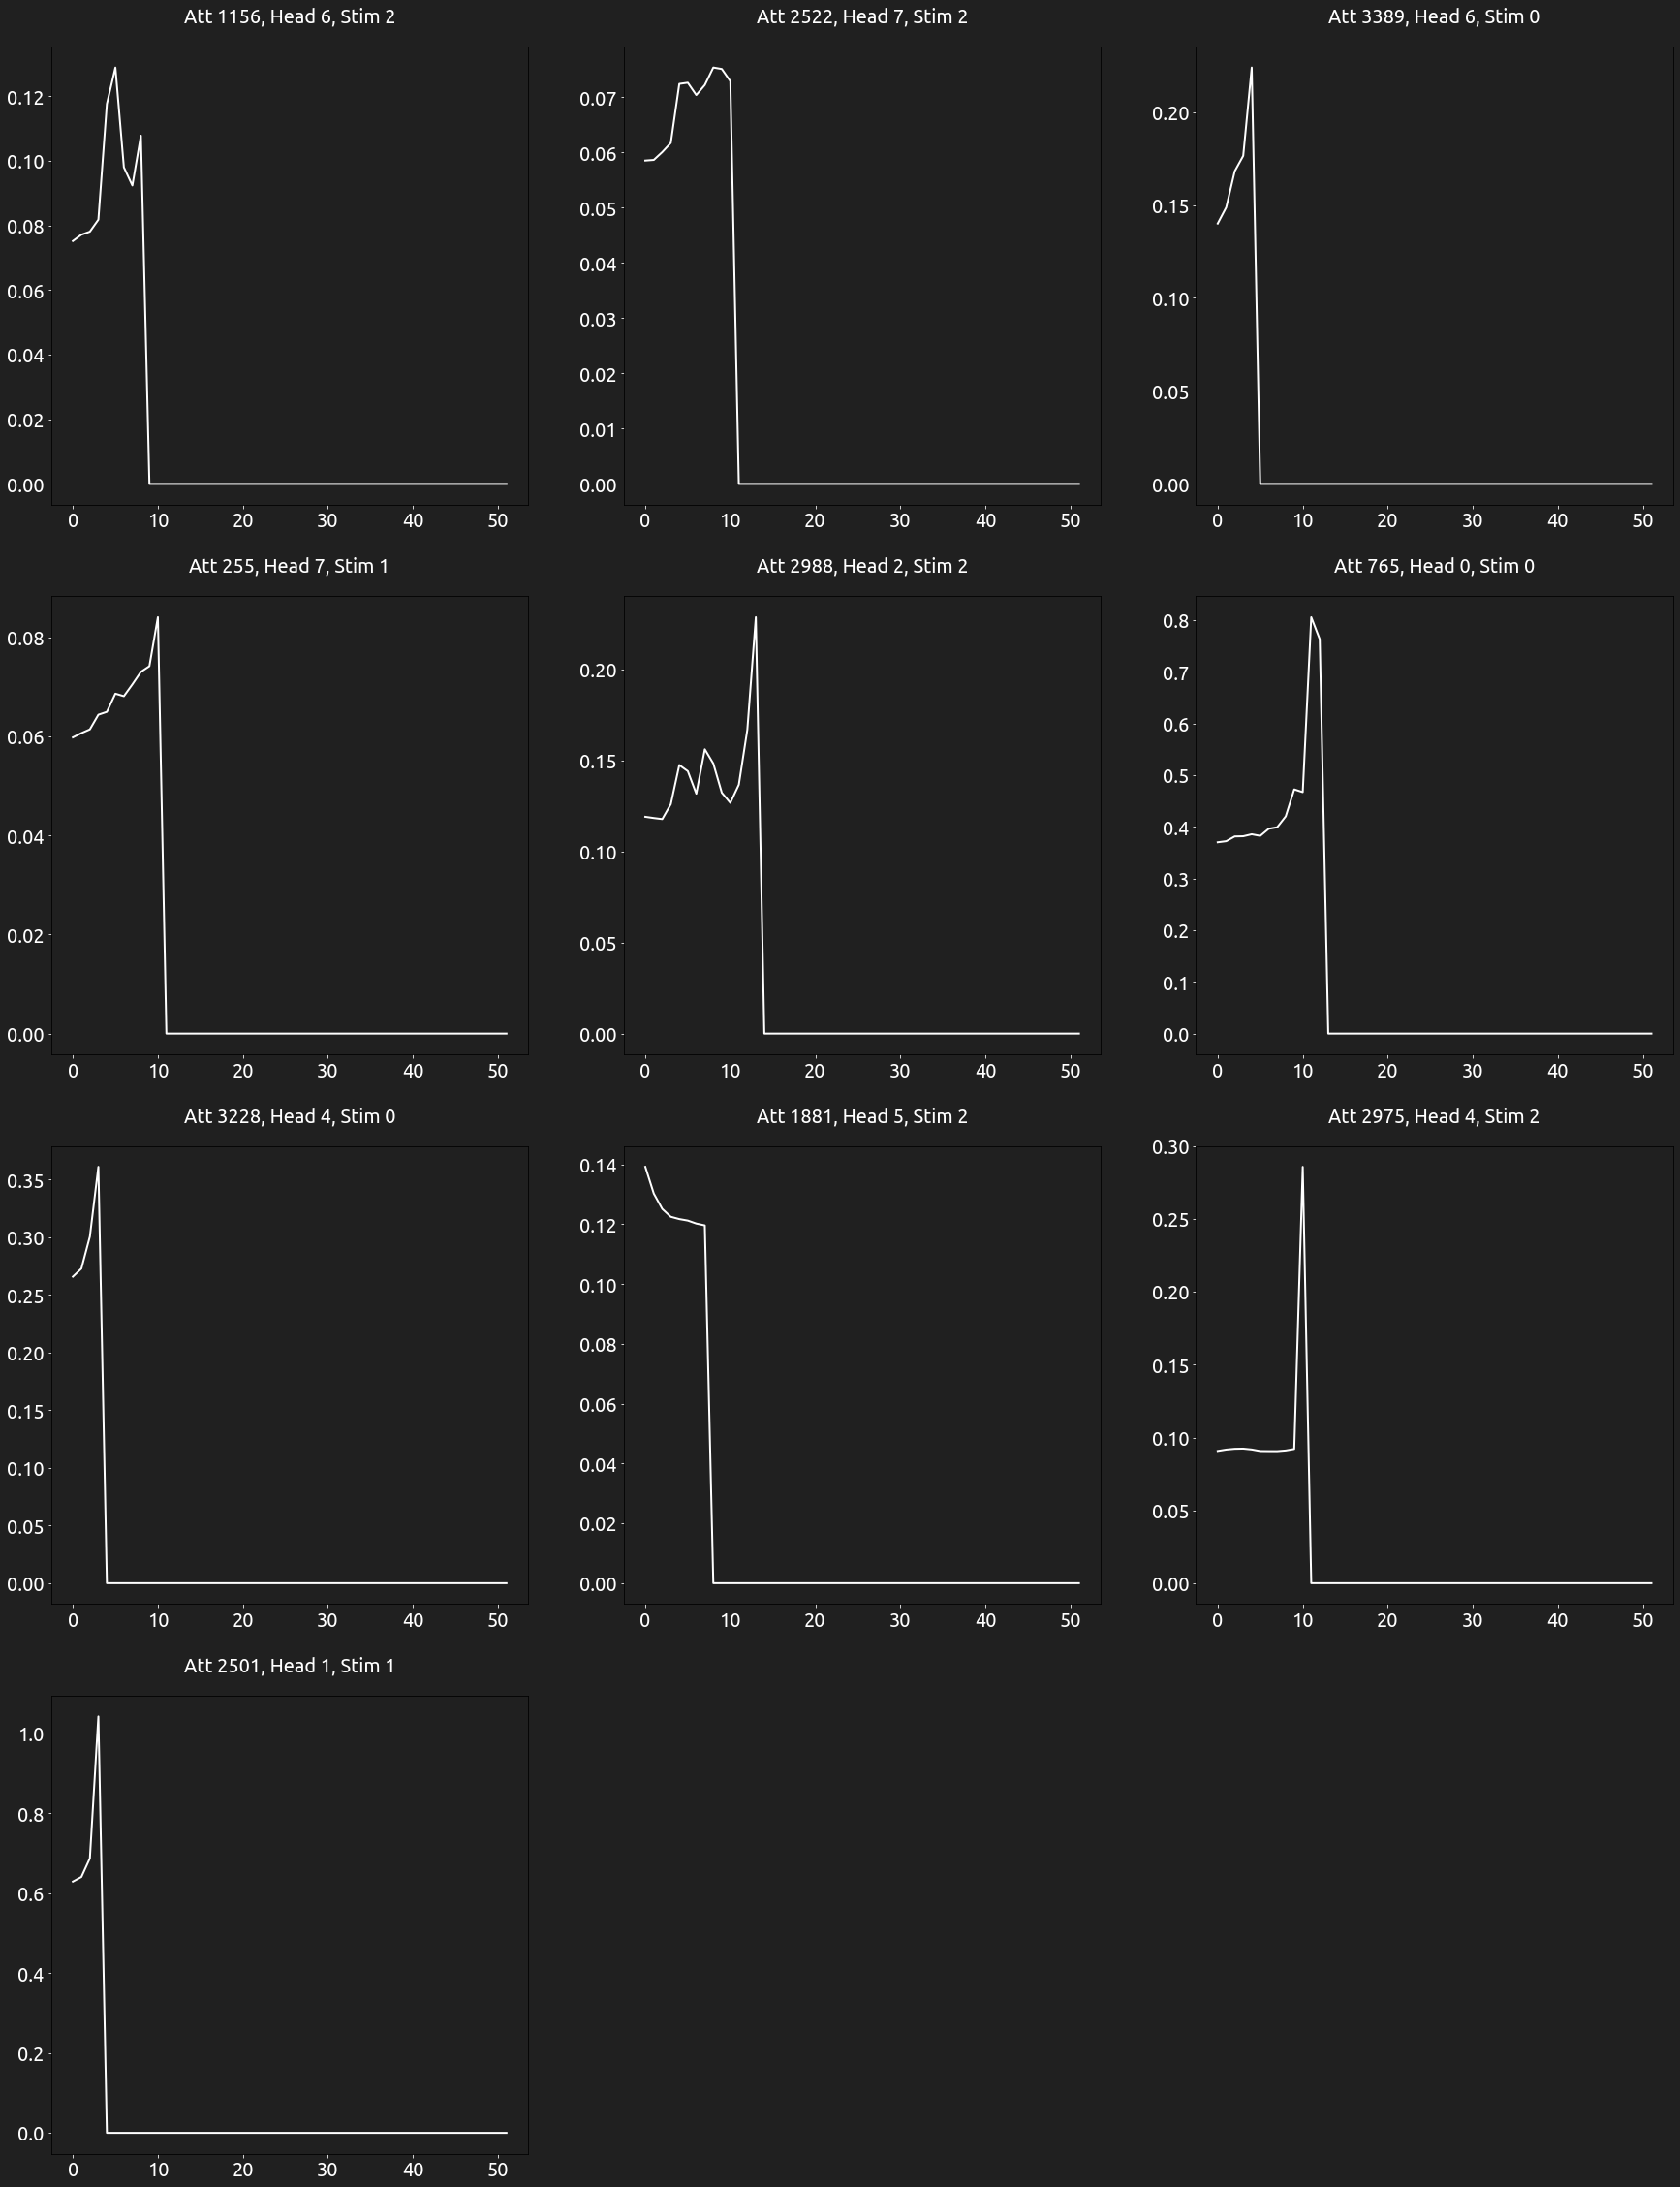

In [125]:
from utils import set_plot_white, set_plot_black
set_plot_black()
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import softmax

# ix_step = [1, 2, 3, 4]
ix_step = 10
ncol = 3
nrow = ix_step // ncol + 1
plt.figure(figsize=(30, 40))

sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
row, head, col = sorted_att_std

sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
row, head, col = sorted_att_std
att_top_std_im = 0
for n, ix in enumerate(range(ix_step)):
    top_n = ix
    # att_std_idx = row[(top_n - 1)], head[(top_n - 1)], col[(top_n - 1)]
    att_idx  = np.random.choice(att_trials_id.shape[0], 1), np.random.choice(att_trials_id.shape[1], 1), np.random.choice(att_trials_id.shape[2], 1)
    att_top_std = att_trials_id[att_idx].flatten()
    # att_top_std_im = F.softmax(torch.tensor(att_top_std), dim=-1).numpy()

    t = df.groupby(['Interval', 'Trial']).size().reset_index().iloc[int(att_idx[0])]
    if t['Trial'] <= 20: n_stim = 0
    elif t['Trial'] <= 40: n_stim = 1
    elif t['Trial'] <= 60: n_stim = 2  

    # # print(n_stim, math.ceil(t['Interval'] * 20))
    # im_interval = vid_stack[n_stim, math.ceil(t['Interval'] * 20) - 1]

    # att_grid = softmax(att_top_std_im / att_top_std_im.max())

    plt.subplot(nrow, ncol, n+1)
    plt.plot(np.arange(len(att_top_std)), att_top_std, color='white', linewidth=2)
    # # im_interval = gaussian_filter(im_interval, sigma=1)
    plt.title(f'Att {int(att_idx[0])}, Head {int(att_idx[1])}, Stim {n_stim}', fontsize=20)

In [ ]:
def get_att_neurons(model, module, loader, n_blocks, block_size, pad_key=None):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = None
    data = dataset
    pbar = tqdm(enumerate(loader), total=len(loader))
    atts = np.zeros(frame_block_size)
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward the model
        _, _, _, = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        # att = np.zeros(len(feat_encodings))
        score_state = AttentionVis.get_attention(module, n_blocks, T, pad)
        score_history = AttentionVis.get_attention(module, n_blocks, T, pad)
        for n, step in enumerate(score_state):
            # weight each attention by how many units there are
            score_state[n] /= (n + 1)

        if attention_scores is None:
                attention_scores = score_state[None, ...]
        else:
            attention_scores = np.vstack((attention_scores, score[None, ...]))

            # att_dict[int(y['id'][:, n])] = step
        # atts[tuple(x['interval'].cpu().numpy().flatten())] = att_dict
    return attention_scores
        # take attentions from last step

In [381]:
def get_att_neurons(model, module, loader, n_blocks, block_size, pad_key=None, curr_state=True, sum_=False):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = np.zeros((mconf.id_vocab_size, mconf.id_vocab_size))
    pbar = tqdm(enumerate(loader), total=len(loader))
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward model to calculate attentions
        _, _, _ = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        att = np.zeros((mconf.id_vocab_size, mconf.id_vocab_size))
        score = AttentionVis.get_attention(module, n_blocks, T)
        score = np.sum(score, axis=0)   # sum over all heads 
        # score = np.sum(score, axis=0)   # sum over all steps
        # take attentions from last step
        # if score.size >= 1: score = score[-1]
        # scores.append(score)
        real_ids = x['id'][..., :T - pad].flatten()
        # score: (52)
        # for idx in range(T - pad):
        #     """ 
        #     for each code in scores,
        #     add its score to the array
        #     """

        # # for current_state:
        # t_seq = T - pad
        # xid = x['id'][..., :T - pad].flatten().tolist()
        # yid = y['id'][..., :T - pad].flatten().tolist()
        # score = score[:T - pad, :T - pad]
        # for step in range(T - pad):
        #     step_score = score[step] / (T - pad - t_seq)
        #     yid_step = yid[step] # get the id we are predicting at this step
        #     att[yid_step][xid] += step_score
        # attention_scores += att
        
        # score = (52, 52)
        t_seq = int(T - x['pad'])
        xid_prev = x['id_prev'][..., :T - x['pad_prev']].flatten().tolist()
        xid = x['id'][..., :t_seq].flatten().tolist()
        yid = y['id'][..., :t_seq].flatten().tolist()
        score = score[:t_seq, :T - x['pad_prev']]
        for step in range(t_seq):
            step_score = score[step]    # / (t_seq - step + 1)
            yid_step = yid[step] # get the id we are predicting at this step
            att[yid_step][xid_prev] += step_score
        attention_scores += att
        # if sum_:
        #     attention_scores = attention_scores.sum(axis=0)
    return attention_scores

In [203]:
from attentionVis import AttentionVis

loader = DataLoader(dataset, shuffle=False, pin_memory=False,
                             batch_size=1, num_workers=1)
iterable = iter(loader)

state_inter_atts = get_att_neurons(model, model.neural_visual_transformer.neural_state_block,
                                   loader, model.config.n_state_layers, mconf.id_block_size, 'pad')

  0%|          | 0/3670 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f95abd32040>
Traceback (most recent call last):
  File "/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f95abd32040>
Traceback (most recent call last):
  File "/home/antonis/anaconda3/envs/transformer_exp/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  

In [354]:
state_inter_atts.shape

(168, 168)

In [382]:
history_inter_atts = get_att_neurons(model, model.neural_visual_transformer.neural_state_history_block,
                          loader, model.config.n_state_history_layers, mconf.id_block_size, 'pad_prev') 

100%|██████████| 3670/3670 [00:58<00:00, 63.15it/s]


In [357]:
history_inter_atts.shape

(168, 168)

In [383]:
def get_rates(df, ids, intervals):
    df = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()['Time']
    def set_rates(df, id, intervals):
        rates = np.zeros_like(intervals)
        if id not in df.index:
            return rates
        else:
            df = df[id]
            for i in df.index:
                n = int((i * 2) - 1)
                rates[n] = df[i]            
            return rates
    rates = dict()
    for id in ids:
        rates[id] = set_rates(df, id, intervals)
    return rates

ids = list(set(df['ID'].unique()))
rates_real = get_rates(df, ids, df['Interval'].unique())

In [384]:
state_inter_corrs = np.corrcoef(list(rates_real.values()))
state_inter_corrs = state_inter_corrs[:len(ids), :len(ids)]
state_inter_corrs = np.where(state_inter_corrs >= 0.99, 0, state_inter_corrs)
state_inter_corrs.shape

(164, 164)

In [385]:
inter_atts = state_inter_atts[:len(ids), :len(ids)]
inter_corrs = state_inter_corrs[:len(ids), :len(ids)]
history_inter_atts = history_inter_atts[:len(ids), :len(ids)]
inter_corrs = np.where(inter_corrs >= 0.99, 0, inter_corrs)

In [405]:
total_atts = inter_atts + history_inter_atts

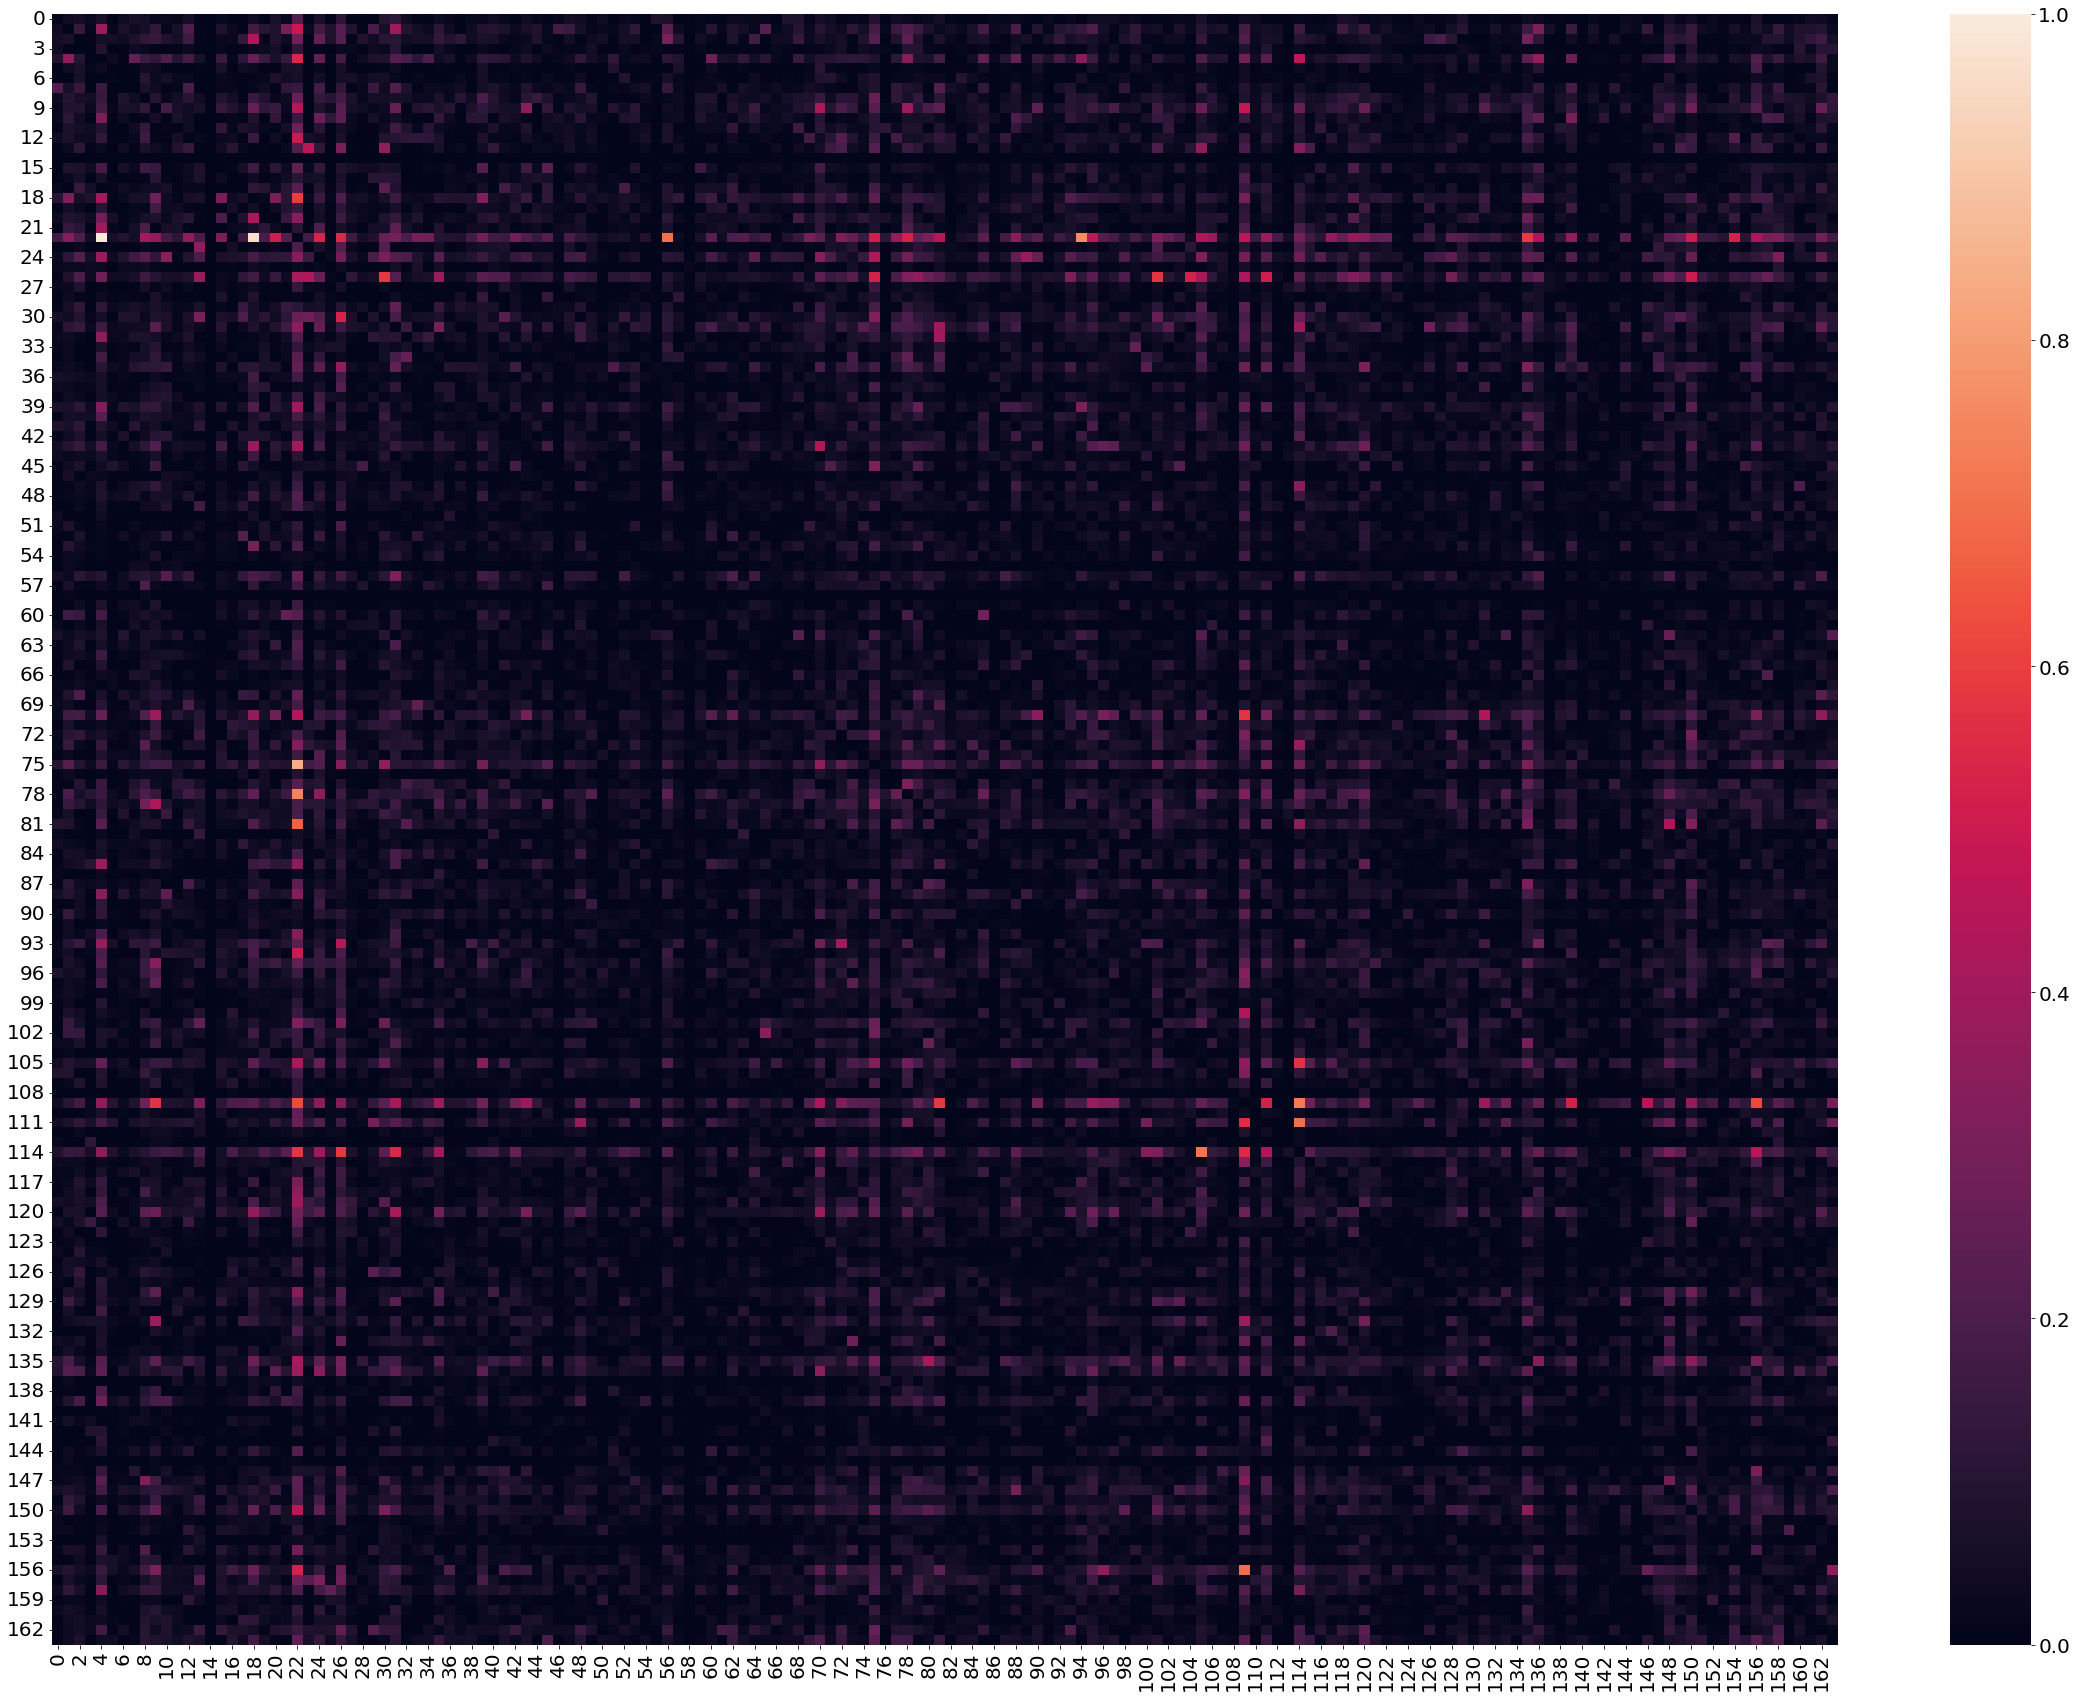

In [406]:
set_plot_white()
plt.figure(figsize=(40,30))
sns.heatmap(inter_atts / inter_atts.max(), annot=False)
plt.show()

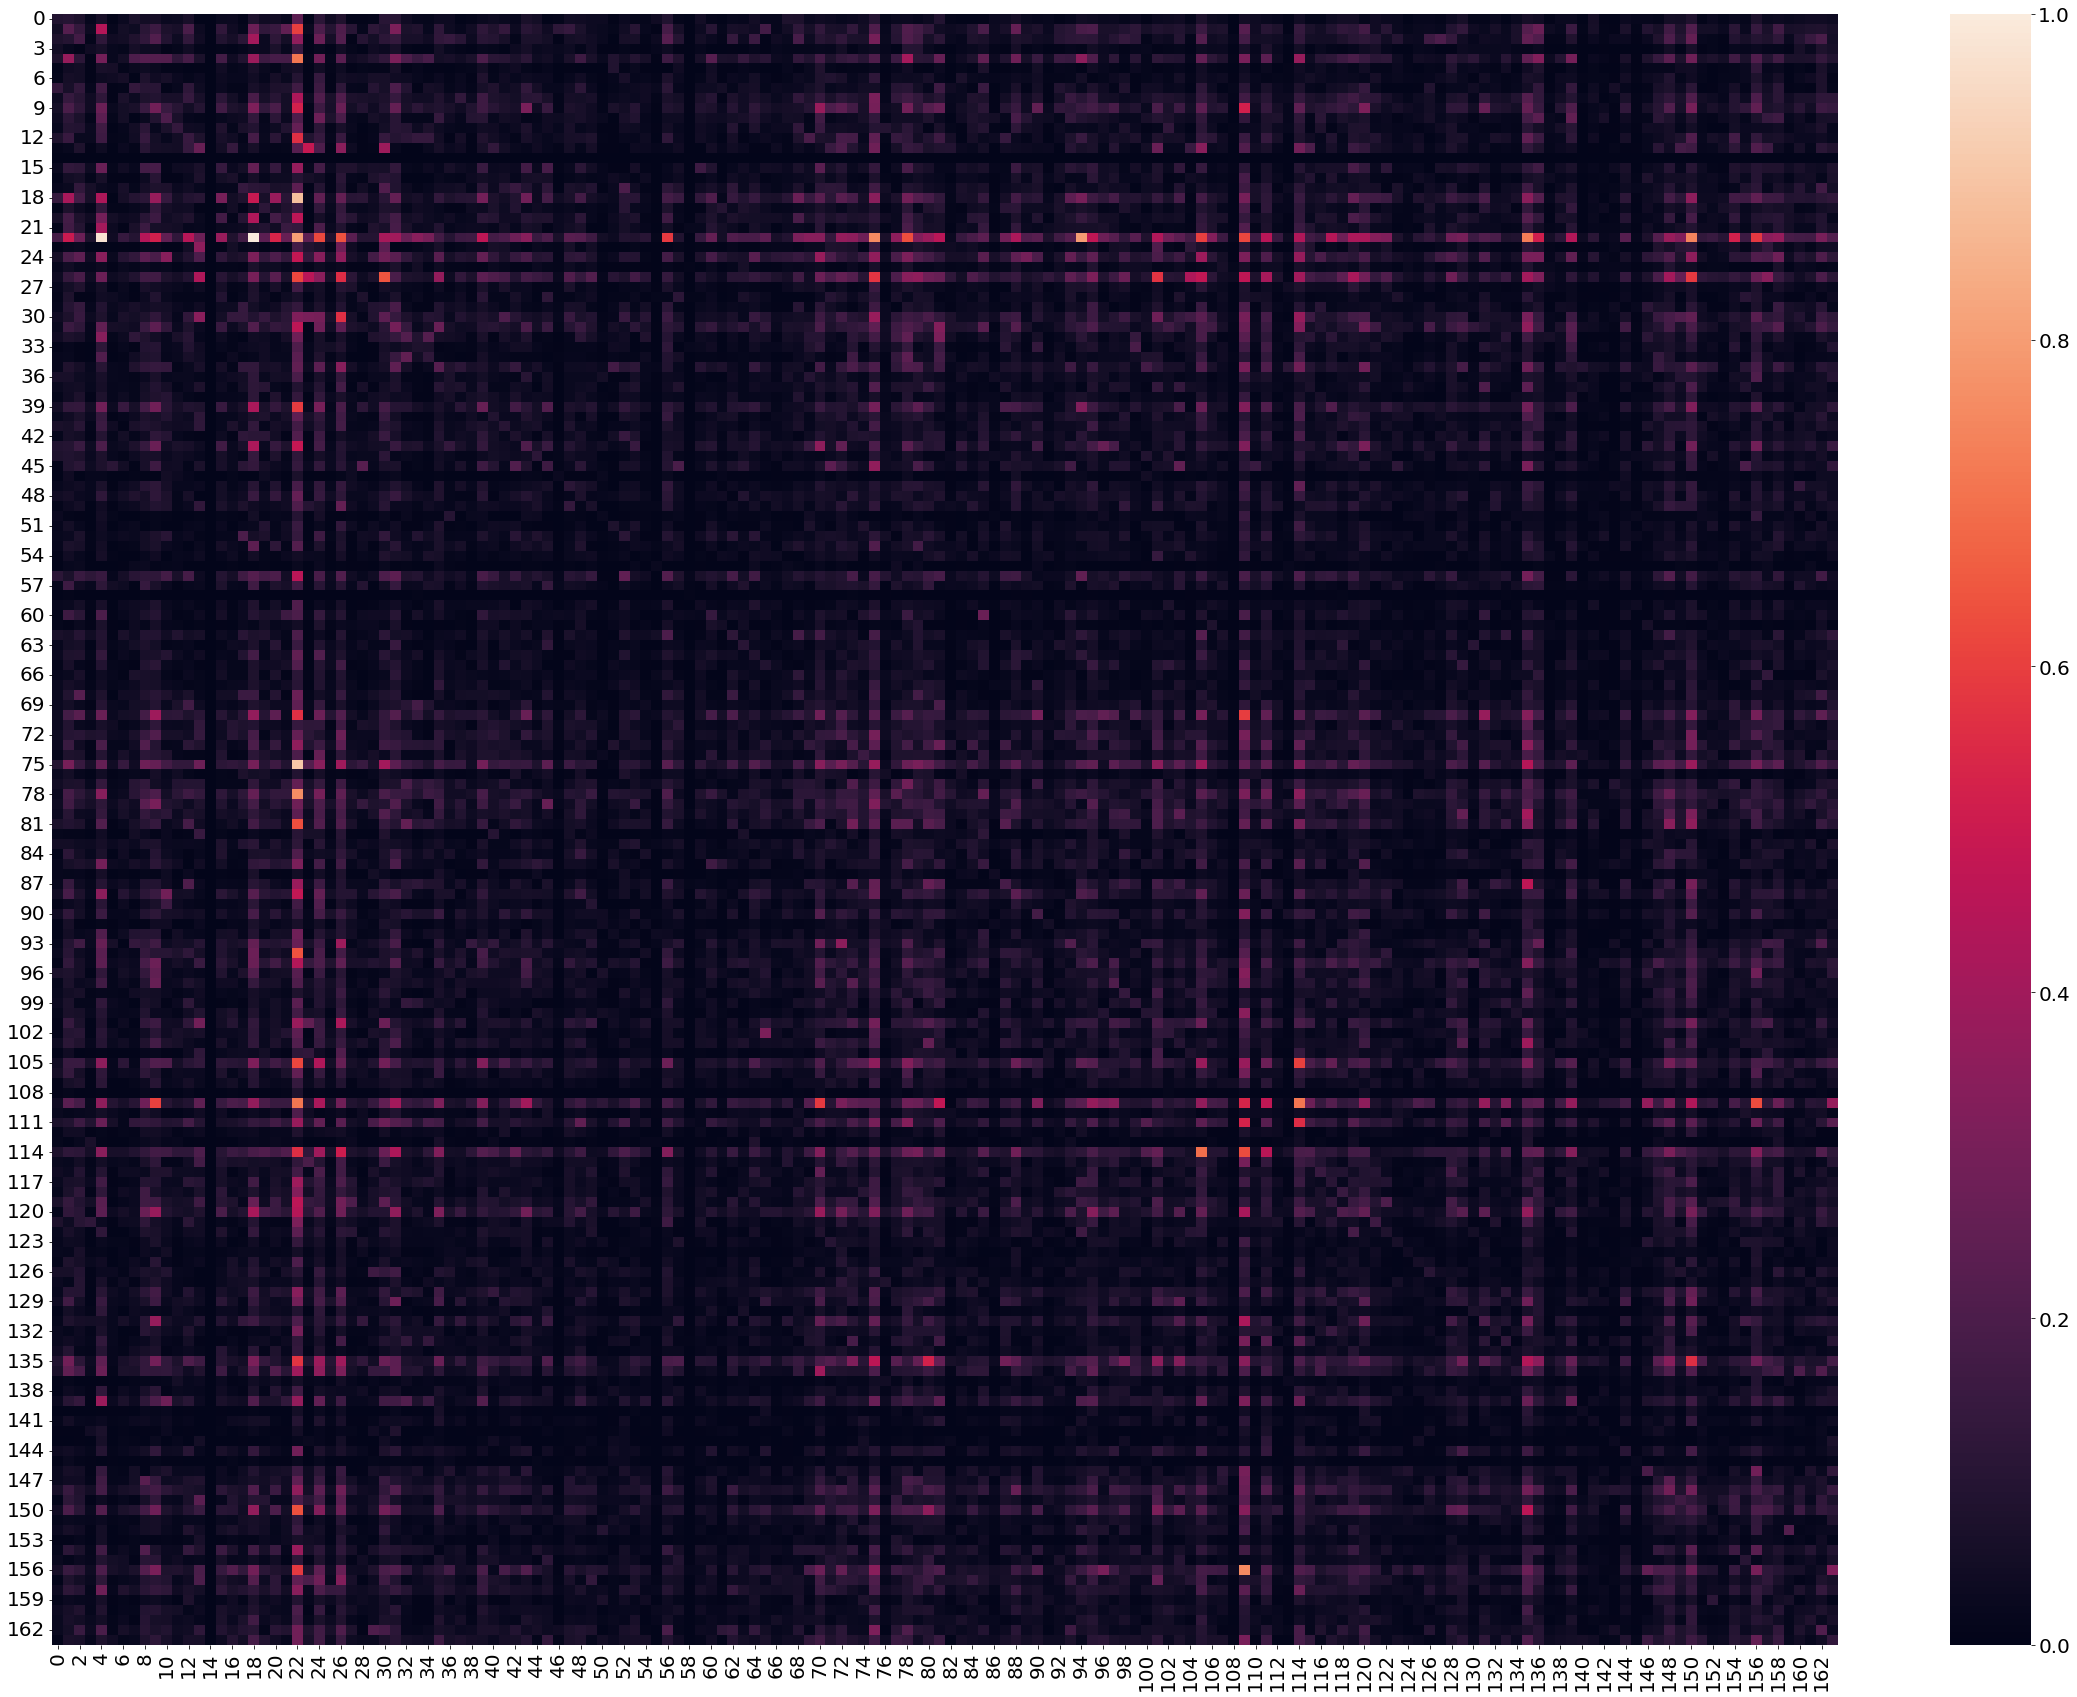

In [407]:
set_plot_white()
plt.figure(figsize=(40,30))
sns.heatmap(total_atts / total_atts.max(), annot=False)
plt.show()

In [397]:
np.linalg.norm(inter_corrs, axis=1).shape

(164,)

In [393]:
inter_corrs.shape

(164, 164)

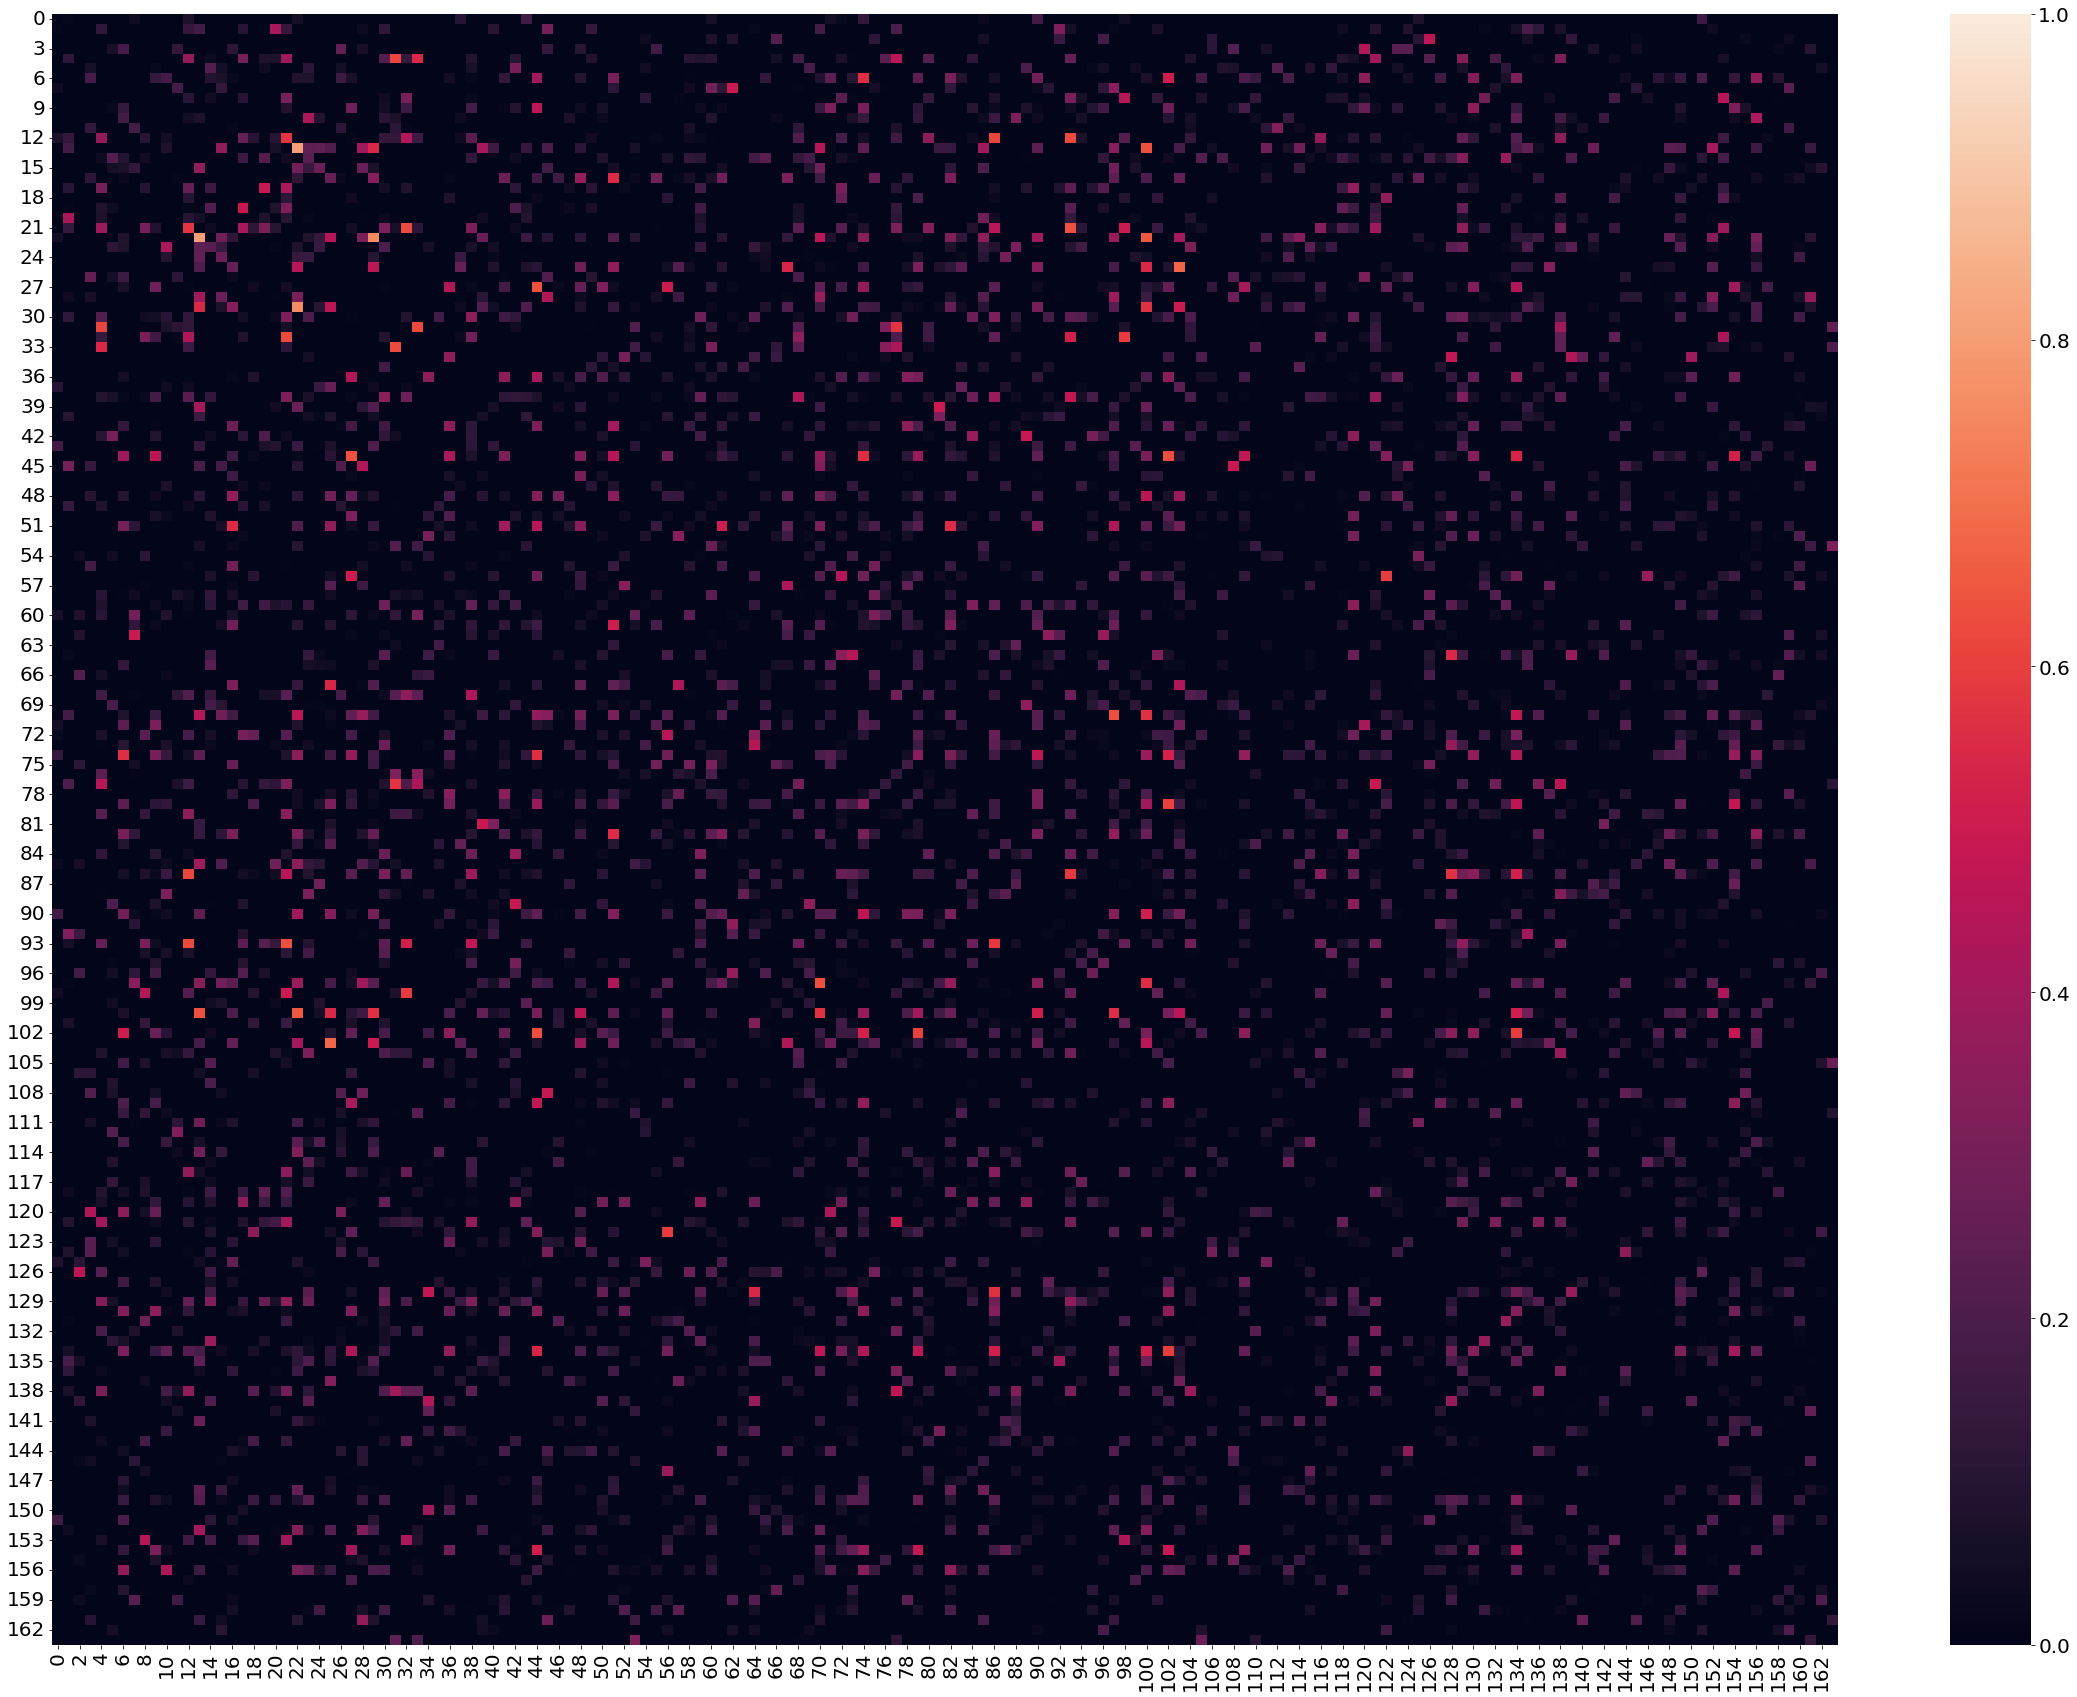

In [399]:
set_plot_white()
plt.figure(figsize=(40,30))
sns.heatmap((inter_corrs - inter_corrs.std()) / inter_corrs.max(), annot=False, vmin=0, vmax=1)
plt.show()

In [299]:
def get_sorted_top_k(array, top_k=1, axis=-1, reverse=False):
    if reverse:
        axis_length = array.shape[axis]
        partition_index = np.take(np.argpartition(array, kth=-top_k, axis=axis),
                                  range(axis_length - top_k, axis_length), axis)
    else:
        partition_index = np.take(np.argpartition(array, kth=top_k, axis=axis), range(0, top_k), axis)
    top_scores = np.take_along_axis(array, partition_index, axis)
    # resort partition
    sorted_index = np.argsort(top_scores, axis=axis)
    if reverse:
        sorted_index = np.flip(sorted_index, axis=axis)
    top_sorted_scores = np.take_along_axis(top_scores, sorted_index, axis)
    top_sorted_indexes = np.take_along_axis(partition_index, sorted_index, axis)
    return top_sorted_scores, top_sorted_indexes

att_score, att_top_idx = get_sorted_top_k(inter_atts, 10)

In [300]:
top_idx = np.argpartition(att_score, -4)

In [301]:
top_idx.shape

(164, 10)

In [312]:
top_n = 15

def get_top_n(array, top_n=20):
    a_1d = array.flatten()
    idx_1d = a_1d.argsort()[-top_n:]
    x_idx, y_idx = np.unravel_index(idx_1d, array.shape)
    return x_idx, y_idx

In [408]:
top_n_atts_idx = get_top_n(total_atts, top_n=100)
top_n_corrs_idx = get_top_n(inter_corrs, top_n=100)

In [409]:
top_n_corrs_idx

(array([108,  45,  89,  42,   7,  62,  29, 103,  98,  21,  39,  81,  56,
         27,  51,  61,   6, 102, 134, 100, 100,  90, 154,  44,  93,  32,
        134,  86, 102,  74,  67,  25, 134,  44, 128,  64, 100,  25,   4,
         33,  13,  29,  16,  51,  82,  51, 100,  97,   6,  74,  74,  44,
        100,  70,  86, 128, 100,  29,  31,  77,  12,  21,  86,  93,  32,
         98, 122,  56, 134, 102,  79, 102,  31,   4,  12,  86,  93,  12,
         21,  32,  33,  31, 102,  44,  97,  70, 100,  13,  93,  21,  44,
         27,  22, 100, 103,  25,  29,  22,  13,  22]),
 array([ 45, 108,  42,  89,  62,   7, 103,  29,  21,  98,  81,  39,  27,
         56,  61,  51, 102,   6, 100, 134,  90, 100,  44, 154,  32,  93,
         86, 134,  74, 102,  25,  67,  44, 134,  64, 128,  25, 100,  33,
          4,  29,  13,  51,  16,  51,  82,  97, 100,  74,   6,  44,  74,
         70, 100, 128,  86,  29, 100,  77,  31,  21,  12,  93,  86,  98,
         32,  56, 122, 102, 134, 102,  79,   4,  31,  86,  12,  12,  

In [410]:
inter_corrs

array([[ 0.        ,  0.16987397,  0.02309071, ..., -0.09968196,
         0.13036972,  0.04928889],
       [ 0.16987397,  0.        , -0.09264295, ...,  0.06069769,
        -0.16610526, -0.10108144],
       [ 0.02309071, -0.09264295,  0.        , ..., -0.0931309 ,
         0.11044857, -0.13889529],
       ...,
       [-0.09968196,  0.06069769, -0.0931309 , ...,  0.        ,
        -0.03949541,  0.26583251],
       [ 0.13036972, -0.16610526,  0.11044857, ..., -0.03949541,
         0.        ,  0.0060858 ],
       [ 0.04928889, -0.10108144, -0.13889529, ...,  0.26583251,
         0.0060858 ,  0.        ]])

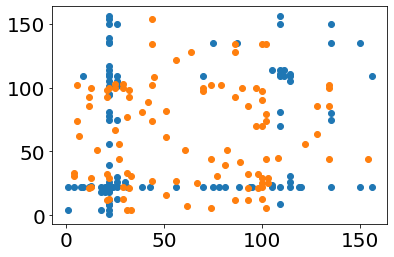

In [412]:
plt.scatter(top_n_atts_idx[0], top_n_atts_idx[1])
plt.scatter(top_n_corrs_idx[0], top_n_corrs_idx[1])

In [413]:
inter_atts.shape

(164, 164)

In [414]:
df_atts = pd.DataFrame(inter_atts)

In [253]:
df_atts.nlargest(10, columns=df_atts.columns)

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
7,20.996446,6.515389,14.017268,0.000000,15.170130,0.000000,0.000000,0.000000,6.972245,4.253766,...,7.737503,2.274322,14.684691,4.635124,14.767634,0.000000,1.137927,1.383735,10.565289,0.000000
22,17.597747,33.200234,20.345412,4.591236,100.927117,5.713839,8.972759,4.779092,40.450820,36.793177,...,52.848797,10.459228,42.614631,30.646678,31.663880,19.791362,12.120478,11.168650,29.671457,17.604564
135,10.410213,19.238090,6.260370,1.280917,21.484751,1.625342,2.124840,5.046097,10.493701,23.678147,...,4.220741,3.304629,29.745043,10.288881,10.093498,3.011693,4.728386,2.160353,8.413486,19.468171
18,10.082989,31.390528,5.413032,8.129672,40.453383,0.343561,2.884639,6.163443,6.568959,28.448196,...,15.535939,8.895449,17.594678,17.295337,3.619333,8.384720,5.680829,3.536951,5.024715,7.013416
75,9.679532,22.686412,9.264367,3.216143,15.166592,1.483112,11.181870,6.065179,14.331174,17.972373,...,10.451468,11.455867,22.382069,11.040722,24.015819,1.421816,7.157552,7.152078,18.278272,21.352805
81,9.535778,8.119932,1.721150,0.000000,22.811206,0.000000,1.432540,3.586424,7.807568,8.474139,...,2.897069,1.530654,13.067155,3.196802,4.504375,3.302370,3.794156,2.102011,23.226909,8.932038
106,9.066043,9.252041,0.598346,0.000000,9.185694,0.225211,3.287310,2.644411,14.172405,6.632474,...,4.794309,2.413217,19.544975,1.012462,6.230743,6.864612,4.925864,0.000000,0.000000,6.018022
136,8.778400,22.013709,19.595849,3.022963,23.741352,0.270918,8.306010,3.775825,10.574021,7.023499,...,5.796816,14.575416,3.780585,11.053779,18.848265,3.402250,19.311923,7.351233,15.833950,2.353061
114,8.665032,14.204456,13.482737,5.731876,35.145594,8.310816,2.859607,7.341661,9.867371,15.099972,...,7.601653,13.625924,46.022082,16.731433,18.954935,7.884883,4.958855,4.981397,24.443094,15.146104
4,8.583261,37.045915,9.878834,0.000000,0.000000,3.284134,0.583755,25.545314,16.155028,12.670439,...,6.955132,4.917747,21.655627,7.621376,14.425575,4.592317,8.437974,6.564690,15.999248,2.268627


In [261]:
df_atts.nlargest(10, columns=df_atts.columns).idxmax()

0        7
1        4
2       22
3       18
4       22
      ... 
159     22
160    136
161     22
162     22
163     75
Length: 164, dtype: int64